# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Проверка гипотезы для сервиса Яндекс книги

- Автор: Загиров А.А.


## Цели и задачи проекта

Команда сервиса Яндекс Книги изучила данные, полученные при анализе LTV, и выдвинула гипотезу. Она заключается в том, что пользователи, которые приносят больший LTV, являются более лояльными, а значит, проводят в среднем больше времени за чтением и прослушиванием книг в приложении.
Команда предлагает сравнить пользователей из Санкт-Петербурга и Москвы, ведь при расчётах среднего LTV было определено, что эта метрика у петербуржцев выше. Таким образом, гипотеза выглядит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы. 

## Описание данных

файл `yandex_knigi_data.csv` содержит данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности

## Содержимое проекта

- Загрузка данных и знакомство с ними
- Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп и их статистики.
- Предобработка данных
- Исследовательский анализ данных
- Итоговый вывод и рекомендации


## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Импортируем библиотеки
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Выгружаем данные в переменные
knigi_data_df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [3]:
# Выводим первые строки датафрейма на экран
knigi_data_df

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434
...,...,...,...,...
8779,8779,Санкт-Петербург,1130000028554332,4.107774
8780,8780,Санкт-Петербург,1130000030307246,45.069222
8781,8781,Санкт-Петербург,1130000038726322,0.211944
8782,8782,Санкт-Петербург,1130000047892100,4.311841


In [4]:
knigi_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [5]:
knigi_data_df = knigi_data_df.drop('Unnamed: 0', axis=1)

In [6]:
# проверяем на независимость групп
A_inter = knigi_data_df[knigi_data_df['city']=='Москва']['puid']
B_inter = knigi_data_df[knigi_data_df['city']=='Санкт-Петербург']['puid']

intersection = list(set(A_inter) & set(B_inter))
print(len(intersection))

244


In [7]:
A_inter

0                   9668
1                  16598
2                  80401
3                 140205
4                 248755
              ...       
6229    1130000059765086
6230    1130000059999641
6231    1130000060143349
6232    1130000060647736
6233    1130000065762132
Name: puid, Length: 6234, dtype: int64

In [8]:
knigi_data_df = knigi_data_df[~knigi_data_df['puid'].isin(intersection)] 

In [9]:
knigi_data_df_group_day = knigi_data_df.groupby('city').agg(all=('puid', 'nunique')).reset_index()
knigi_data_df_group_day

,city,all
0,Москва,5990
1,Санкт-Петербург,2306


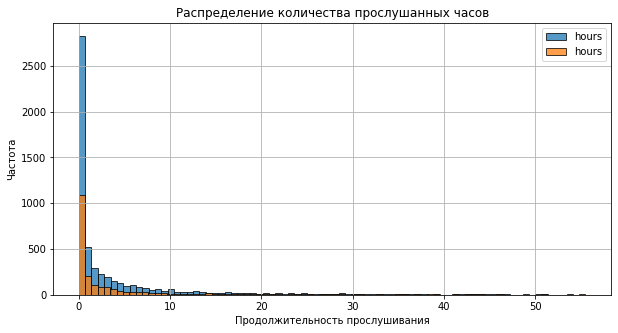

In [10]:
cleaned_page_counter = knigi_data_df[knigi_data_df['hours'] <= knigi_data_df['hours'].quantile(0.95)]

plt.figure(figsize=(10, 5))

# Строим гистограмму с помощью pandas через plot(kind='hist')
cleaned_page_counter[cleaned_page_counter['city']=='Москва']['hours'].plot(
                kind='hist', # Тип графика — гистограмма
                bins=80, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
)

cleaned_page_counter[cleaned_page_counter['city']=='Санкт-Петербург']['hours'].plot(
                kind='hist', # Тип графика — гистограмма
                bins=80, # Устанавливаем количество корзин
                alpha=0.75,
                edgecolor='black',
)


# Настраиваем оформление графика
plt.title('Распределение количества прослушанных часов')
plt.xlabel('Продолжительность прослушивания')
plt.ylabel('Частота')
plt.legend()

# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show() 





In [11]:
# Вычисляем средние
display(cleaned_page_counter[cleaned_page_counter['city']=='Москва']['hours'].mean())
display(cleaned_page_counter[cleaned_page_counter['city']=='Санкт-Петербург']['hours'].mean())

4.641440177240952

4.971759345003627

In [12]:
# Вычисляем стандартное отклонение
display(cleaned_page_counter[cleaned_page_counter['city']=='Москва']['hours'].std())
display(cleaned_page_counter[cleaned_page_counter['city']=='Санкт-Петербург']['hours'].std())

9.065173764185792

9.832974425119525

Получили датафрейм `knigi_data_df` в котором 8784 строк. Нет пустых значчений, типы данных соответствует. 
Для Москвы количество пользователей равно 5990, для Санкт-Петербурга - 2306. 
Построили гистограммы для анализа распределения данных. Данные распределенны одинаково. 
Средние значения примерно одинаковые 4.64 и 4.97

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



In [13]:
# проверяем используя статистический тест Т-тест Уэлча и Стьюдена
metric_a = knigi_data_df[knigi_data_df.city=='Москва']['hours'] ## выборка целевой метрики для группы A
metric_b = knigi_data_df[knigi_data_df.city=='Санкт-Петербург']['hours'] ## выборка целевой метрики для группы B

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False) ## применяем t-тест Уэлча
if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 4)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Интерпретация: среднее время активности в двух выборках не различается')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 4)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Интерпретация: среднее время активности в двух выборках различается')

p-value теста Уэлча =0.6636
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны
Интерпретация: среднее время активности в двух выборках не различается


Пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы, значения средних показывают 4.64 для Москвы и 4.97 для Санкт-Петербурга. 
Для проведения анализа используем одностороннюю проверку гипотезы с двумя выборками:
* Нулевая гипотеза H0 : μСПб ≤μ Москва  
Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.
* Альтернативная гипотеза H1 : μСПб >μМосква.
Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Тип основной метрики средняя пользовательская. Для анализа данных выбираем т-тест. Выборки достаточны (более 30 в каждой), средние почти равны, стандартные отклонения тоже несильно различаются (значит дисперсии примерно равны ), нет сильных выборосов.
Уровень статистической значимости устанавливаем равным 5% (α=0.05).
Среднее время активности в двух выборках не различается.
По результату теста определили, что среднее время активности в двух выборках не различается.
Возможно мы получили более высокое среднее из-за разницы размера выборок и выбросов в данных из 'Санкт-Петербурга'

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. Предполагается, что это повысит количество пользователей, которые совершат покупку.
Необходимо провести A/B-тест для новой версии сайта и сделать оценку результатов.

## 2. Загрузите данные, оцените их целостность.


In [14]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [15]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [16]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [17]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [18]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [19]:
# проверяем дубликаты по событиям
events.duplicated().sum()

36318

In [20]:
events = events.drop_duplicates()

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [21]:
participants_test=participants[participants['ab_test']=='interface_eu_test']

In [22]:
participants_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10850 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  10850 non-null  object
 1   group    10850 non-null  object
 2   ab_test  10850 non-null  object
 3   device   10850 non-null  object
dtypes: object(4)
memory usage: 423.8+ KB


In [23]:
# проверяем дубликаты
participants_test['user_id'].duplicated().sum()

0

In [24]:
# проверяем на независимость групп
A_inter = participants_test[participants_test['group']=='A']['user_id']
B_inter = participants_test[participants_test['group']=='B']['user_id']

intersection = list(set(A_inter) & set(B_inter))
print(len(intersection))

0


In [25]:
print(len(participants_test))


10850


In [26]:
participants_b_rec_test=participants[(participants['group']=='B')&(participants['ab_test']=='recommender_system_test')]['user_id']
participants_b_inter_test=participants[(participants['group']=='B')&(participants['ab_test']=='interface_eu_test')]['user_id']

intersection_b = list(set(participants_b_rec_test) & set(participants_b_inter_test))

display(len(intersection_b))

116

In [27]:
participants_test = participants_test[~participants_test['user_id'].isin(intersection_b)] 

In [28]:
print(len(participants_test))


10734


In [29]:
# проверяем количество пользователей в группах и процент
participants_group= participants_test.groupby('group').agg(all=('user_id', 'nunique')).reset_index()
participants_group['%'] = 100 * participants_group['all'] / participants_group['all'].sum()
participants_group

,group,all,%
0,A,5383,50.149059
1,B,5351,49.850941


In [30]:
# создаем список с пользователями, которые участвуют в тесте
spr=list(participants_test['user_id'])   

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [31]:
# выбираем только те события, пользователи которых есть в списке участников теста 'spr' из датафрейма 'participants_test'
events_change=events[events['user_id'].isin(spr)]
events_change.shape[0]

72935

In [32]:
# выбираем только время регистрации
events_change_new = events_change[events_change['event_name'] == 'registration'][['user_id', 'event_dt']]
events_change_new = events_change_new.rename(columns={'event_dt': 'install_date'})

events_change_new

,user_id,install_date
64672,5F506CEBEDC05D30,2020-12-06 14:10:01
64946,51278A006E918D97,2020-12-06 14:37:25
66585,A0C1E8EFAD874D8B,2020-12-06 17:20:22
67873,275A8D6254ACF530,2020-12-06 19:36:54
67930,0B704EB2DC7FCA4B,2020-12-06 19:42:20
...,...,...
654517,52B5A81EFC31AF1D,2020-12-23 23:44:45
654518,B1D88FBD4BA58E1B,2020-12-23 23:44:47
654581,38CA3A3C4FE3FEFD,2020-12-23 23:47:47
654640,16CCB1C8C4DCF1AF,2020-12-23 23:50:29


In [33]:
# объединяем с таблицей пользователей, участвующих в тесте
participants_test_new = participants_test.merge(events_change_new, on='user_id', how='left')[['user_id', 'group', 'device', 'install_date']]
participants_test_new

,user_id,group,device,install_date
0,0002CE61FF2C4011,B,Mac,2020-12-07 04:37:31
1,001064FEAAB631A1,A,Android,2020-12-20 14:12:45
2,001E72F50D1C48FA,A,Mac,2020-12-17 15:44:05
3,002412F1EB3F6E38,B,Mac,2020-12-09 09:36:50
4,002540BE89C930FB,B,Android,2020-12-08 18:06:07
...,...,...,...,...
10729,FFE5B14BD55C1C5C,A,PC,2020-12-19 06:27:24
10730,FFE600EEC4BA7685,B,Android,2020-12-13 21:43:31
10731,FFE7FC140521F5F6,A,PC,2020-12-23 09:10:16
10732,FFEFC0E55C1CCD4F,A,PC,2020-12-13 23:52:15


In [34]:
# объединяем с таблицей событий, все данные в одной таблице
events_change_inst=events_change.merge(participants_test_new, on='user_id', how='left')
events_change_inst

,user_id,event_dt,event_name,details,group,device,install_date
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,iPhone,2020-12-06 14:10:01
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,A,Android,2020-12-06 14:37:25
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,B,iPhone,2020-12-06 17:20:22
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,A,iPhone,2020-12-06 19:36:54
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,B,PC,2020-12-06 19:42:20
...,...,...,...,...,...,...,...
72930,F80C9BDDEA02E53C,2020-12-30 10:02:43,purchase,4.49,B,iPhone,2020-12-07 10:05:54
72931,F80C9BDDEA02E53C,2020-12-30 10:03:51,purchase,4.49,B,iPhone,2020-12-07 10:05:54
72932,F80C9BDDEA02E53C,2020-12-30 10:03:52,product_cart,NaN,B,iPhone,2020-12-07 10:05:54
72933,6181F3835EBE66BF,2020-12-30 12:10:39,product_cart,NaN,B,Android,2020-12-07 19:53:20


In [35]:
# вычисляем количество дней с момента регистрации до покупки
events_change_inst['day_event'] = (events_change_inst['event_dt'] - events_change_inst['install_date']).dt.days
events_change_inst['install_day'] = events_change_inst['install_date'].dt.date
# events_change_inst = events_change_inst.drop('install_date', axis=1) 
events_change_inst

,user_id,event_dt,event_name,details,group,device,install_date,day_event,install_day
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,iPhone,2020-12-06 14:10:01,0,2020-12-06
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,A,Android,2020-12-06 14:37:25,0,2020-12-06
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,B,iPhone,2020-12-06 17:20:22,0,2020-12-06
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,A,iPhone,2020-12-06 19:36:54,0,2020-12-06
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,B,PC,2020-12-06 19:42:20,0,2020-12-06
...,...,...,...,...,...,...,...,...,...
72930,F80C9BDDEA02E53C,2020-12-30 10:02:43,purchase,4.49,B,iPhone,2020-12-07 10:05:54,22,2020-12-07
72931,F80C9BDDEA02E53C,2020-12-30 10:03:51,purchase,4.49,B,iPhone,2020-12-07 10:05:54,22,2020-12-07
72932,F80C9BDDEA02E53C,2020-12-30 10:03:52,product_cart,NaN,B,iPhone,2020-12-07 10:05:54,22,2020-12-07
72933,6181F3835EBE66BF,2020-12-30 12:10:39,product_cart,NaN,B,Android,2020-12-07 19:53:20,22,2020-12-07


In [36]:
# определяем сколько пользователей зарегистрировались по дням.
events_change_inst_group = events_change_inst.groupby(['install_day'])['user_id'].nunique().reset_index()
events_change_inst_group.head(30)

,install_day,user_id
0,2020-12-06,13
1,2020-12-07,891
2,2020-12-08,559
3,2020-12-09,403
4,2020-12-10,479
5,2020-12-11,415
6,2020-12-12,718
7,2020-12-13,751
8,2020-12-14,983
9,2020-12-15,548


Мы выбрали данные по техзаданию, необходимые для проверки теста Вычислили для каждого пользователя дату регистрации и количество дней до события в таблице 'events'. Сгруппировав по дням количество регистраций, получаем, что меньше всего регистрировались "2020-12-06" и "2020-12-24", максимальное количество зарегистрированных было "2020-12-21" 1134 пользователя. Но так как нам нужно определить, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта, выбираем с 2020-12-06, фильтруя по количеству дней с момента регистрации.

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [37]:
# определяем сколько пользователей зарегистрировались по дням.
events_change_for_test = events_change_inst[(events_change_inst['day_event']<7)&((events_change_inst['event_name']=='registration')|(events_change_inst['event_name']=='purchase'))]
events_change_for_test

,user_id,event_dt,event_name,details,group,device,install_date,day_event,install_day
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,iPhone,2020-12-06 14:10:01,0,2020-12-06
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,A,Android,2020-12-06 14:37:25,0,2020-12-06
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,B,iPhone,2020-12-06 17:20:22,0,2020-12-06
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,A,iPhone,2020-12-06 19:36:54,0,2020-12-06
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,B,PC,2020-12-06 19:42:20,0,2020-12-06
...,...,...,...,...,...,...,...,...,...
72628,96371D85BF5A99DD,2020-12-29 19:11:11,purchase,4.49,B,iPhone,2020-12-23 13:16:19,6,2020-12-23
72631,96371D85BF5A99DD,2020-12-29 19:12:42,purchase,89.99,B,iPhone,2020-12-23 13:16:19,6,2020-12-23
72666,2CD92B2BD7A136C2,2020-12-29 19:47:22,purchase,4.49,B,PC,2020-12-22 22:27:30,6,2020-12-22
72667,2CD92B2BD7A136C2,2020-12-29 19:47:38,purchase,4.49,B,PC,2020-12-22 22:27:30,6,2020-12-22


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [38]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1-beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [39]:
# проверяем количество пользователей в группах и процент
events_change_group_test= events_change_for_test.groupby(['group', 'event_name']).agg(all_users=('user_id', 'nunique')).reset_index()
events_change_group_test['%'] = events_change_group_test.groupby('group')['all_users'].apply(lambda x: 100 * x / float(x.max()))
events_change_group_test

,group,event_name,all_users,%
0,A,purchase,1480,27.493962
1,A,registration,5383,100.000000
2,B,purchase,1579,29.508503
3,B,registration,5351,100.000000


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

Врезультате вычислений получили датафрейм с событиями с количеством дней с момента регистрации равном 7.
По количеству пользователей совершивших покупку, в группе В это 29.5 % от общего количества в группе, в А - 27.5%. 

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Пусть {nA,nB} — это размеры выборок A и B, а {mA,mB} — количество успехов в выборках A и B.
сформулируем гипотезы для Z-теста пропорций:
Нулевая гипотеза «вероятности успеха равны между группами A и B» — H0:pA=pB.
Альтернативная гипотеза.
Односторонняя. Вероятность успеха в группе B выше, чем в группе A — H1:pA<pB.

Гипотеза заключается в том, что для тестовой группы В, упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе 
конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

In [40]:
# размер группы A


n_a = events_change_for_test[(events_change_for_test.group=='A')&(events_change_for_test.event_name=='registration')].shape[0] # посчитали размер группы А

n_b = events_change_for_test[(events_change_for_test.group=='B')&(events_change_for_test.event_name=='registration')].shape[0] # посчитали размер группы B

m_a = events_change_for_test[(events_change_for_test.group=='A')&(events_change_for_test.event_name=='purchase')]['user_id'].nunique()
# посчитали кол-во успехов в группе A

m_b = events_change_for_test[(events_change_for_test.group=='B')&(events_change_for_test.event_name=='purchase')]['user_id'].nunique()
# посчитали кол-во успехов в группе В

p_a, p_b = m_a/n_a, m_b/n_b # посчитали доли успехов для каждой группы: A и B

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10): # проверили предпосылку о достаточном количестве данных
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha = 0.05 ## установили уровень значимости


stat_ztest, p_value_ztest = proportions_ztest( # провели Z-тест пропорций
	[m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

print(f'pvalue={p_value_ztest}') # вывели полученное p-value 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')


Предпосылка о достаточном количестве данных выполняется!
pvalue=0.010393282955333764
Нулевая гипотеза не находит подтверждения!


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

Провели A/B-тестирования методом Z-тест пропорций.
Получили pvalue=0.010393282955333764.

При расчете конверсии по количеству пользователей совершивших покупку, в группе В это 29.5 % от общего количества в группе, в А - 27.5%. Разница 2%, получается, что требуемое по техзаданию условие увеличения пользователей не выполнилось.

После проведения теста получили подверждение гипотезы.
Гипотеза о том, что упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта потвердилась.
Значит существует статистически значимое различие между долями зарегистрированных пользователей в группах A и B.
Поэтому предполагаем, что конверсия увеличиться на три процента, и разработанную новую версию сайта можно внедрять.  